# Filtro de Spam Multilingüe
Este notebook muestra paso a paso cómo construir un filtro de spam funcional capaz de trabajar con varios idiomas. 
Incluye detección automática de idioma, traducción al inglés si es necesario y un pipeline básico para clasificación.

In [38]:
# Importación de librerías necesarias
from langdetect import detect
from googletrans import Translator

import os
import pandas as pd
import zipfile
import requests
from tqdm.notebook import tqdm


import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## Detección de idioma

Usaremos la librería `langdetect` para identificar automáticamente el idioma de cada mensaje.

In [3]:
# Ejemplo de detección de idioma
sample_texts = [
    "Congratulations! You've won a free ticket.",
    "¡Felicidades! Has ganado una entrada gratis.",
    "Félicitations ! Vous avez gagné un billet gratuit."
]

for text in sample_texts:
    lang = detect(text)
    print(f"Texto: {text}\nIdioma detectado: {lang}\n")

Texto: Congratulations! You've won a free ticket.
Idioma detectado: en

Texto: ¡Felicidades! Has ganado una entrada gratis.
Idioma detectado: es

Texto: Félicitations ! Vous avez gagné un billet gratuit.
Idioma detectado: fr



## Traducción automática

Si el idioma detectado no es inglés, traduciremos el texto usando `googletrans`.

In [4]:
# Ejemplo de traducción automática
translator = Translator()

for text in sample_texts:
    lang = detect(text)
    if lang != "en":
        translated = translator.translate(text, src=lang, dest="en")
        print(f"Original: {text}\nTraducido: {translated.text}\n")
    else:
        print(f"Original (ya en inglés): {text}\n")

Original (ya en inglés): Congratulations! You've won a free ticket.

Original: ¡Felicidades! Has ganado una entrada gratis.
Traducido: Congratulations!Has ganado una entrada gratis.

Original: Félicitations ! Vous avez gagné un billet gratuit.
Traducido: Congratulations !You have won a free ticket.



## Pipeline: Detección de idioma y traducción

Función que detecta el idioma y traduce al inglés si es necesario.

In [6]:
def preprocess_text(text):
    lang = detect(text)
    if lang != "en":
        translated = translator.translate(text, src=lang, dest="en")
        return translated.text, lang
    return text, lang

In [7]:
# Prueba del pipeline
for text in sample_texts:
    processed_text, detected_lang = preprocess_text(text)
    print(f"Idioma original: {detected_lang}\nTexto procesado: {processed_text}\n")

Idioma original: en
Texto procesado: Congratulations! You've won a free ticket.

Idioma original: es
Texto procesado: Congratulations!You have won a free ticket.

Idioma original: fr
Texto procesado: Congratulations !You have won a free ticket.



## Carga y preprocesamiento del dataset SpamAssassin

Vamos a leer los emails de todas las carpetas spam y ham para construir un DataFrame con el texto y la etiqueta correspondiente.

In [8]:
# Definir rutas y etiquetas
folders = [
    ("../data/SpamAssassin/spam", "spam"),
    ("../data/SpamAssassin/spam_2", "spam"),
    ("../data/SpamAssassin/spam_2 2", "spam"),
    ("../data/SpamAssassin/easy_ham", "ham"),
    ("../data/SpamAssassin/easy_ham_2", "ham"),
    ("../data/SpamAssassin/hard_ham", "ham"),
]

In [9]:
# Función para cargar emails de varias carpetas
def load_all_emails(folders):
    emails = []
    for folder, label in folders:
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            if os.path.isfile(filepath):
                with open(filepath, encoding="latin-1") as f:
                    content = f.read()
                    emails.append({"text": content, "label": label})
    return emails

In [14]:
# Cargar todos los emails
all_emails = load_all_emails(folders)
df = pd.DataFrame(all_emails)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Mezclar

In [15]:
# Vista previa
df['label'].value_counts(), df.head()

(label
 ham     4153
 spam    3296
 Name: count, dtype: int64,
                                                 text label
 0  From amc@insurancemail.net  Mon Jun 24 17:08:1...  spam
 1  From ilug-admin@linux.ie  Fri Aug 16 15:02:00 ...   ham
 2  From renturrell22@netscape.net  Wed Jul 31 05:...  spam
 3  From gvyandreamadison55382@hotmail.com  Mon Ju...  spam
 4  Received: from marge.expeditus.co.uk ([213.52....  spam)

## Extracción y limpieza del cuerpo del email

Para preparar los datos y entrenar un filtro de spam eficaz, es importante trabajar solo con el texto relevante de cada email. Los correos electrónicos suelen tener dos partes principales:

- **Headers**: información técnica como remitente, destinatario, asunto, fechas, etc.
- **Cuerpo**: el contenido real del mensaje.

En este proyecto, utilizamos una función que:
1. Separa automáticamente los headers del cuerpo, quedándonos solo con el texto del mensaje.
2. Elimina posibles firmas automáticas que suelen comenzar con dos guiones (`--`).
3. Elimina URLs y espacios extra para limpiar el texto.

Esta limpieza es suficiente para la mayoría de los emails del dataset SpamAssassin, ya que están en formato texto plano. Así, el modelo podrá centrarse en el contenido real del mensaje y no en información irrelevante.

>**Nota:** Si en el futuro se quiere ampliar la limpieza (por ejemplo, para eliminar HTML, procesar adjuntos o eliminar respuestas encadenadas), se pueden añadir pasos adicionales.

In [17]:
def extract_email_body(raw_email):
    # Separar headers del cuerpo (los headers terminan en la primera línea vacía)
    parts = raw_email.split('\n\n', 1)
    body = parts[1] if len(parts) > 1 else parts[0]
    # Eliminar líneas típicas de firmas automáticas
    body = re.sub(r'(--\s*[\r\n].*)', '', body, flags=re.DOTALL)
    # Eliminar URLs y exceso de espacios
    body = re.sub(r'http\S+', '', body)
    body = re.sub(r'\s+', ' ', body)
    return body.strip()

In [18]:
# Aplicar a todos los emails
df['body'] = df['text'].apply(extract_email_body)

In [19]:
# Vista previa
df[['label', 'body']].head()

,label,body
0,spam,This is a multi-part message in MIME format. -...
1,ham,wintermute wrote: >>Anyone know where in Irela...
2,spam,Opportunity is knocking. Why? Because mortgage...
3,spam,We are desperately looking for 100 lazy people...
4,spam,"If Amateurs is what you want, Then we Have the..."


## Selección de modelos clásicos: **Naive Bayes** y **SVM**

Para abordar la detección de spam en emails, es fundamental comparar diferentes enfoques de machine learning. En este proyecto, hemos decidido entrenar y evaluar dos modelos clásicos ampliamente utilizados en la clasificación de texto:

**1. Naive Bayes (MultinomialNB):**
- Es el modelo de referencia tradicional para el filtrado de spam debido a su simplicidad, velocidad y eficacia en problemas de texto.
- Asume independencia entre palabras, lo que, aunque no siempre es realista, funciona muy bien en la práctica para tareas como la detección de spam.
- Es ideal como baseline para comparar con modelos más complejos.

**2. Support Vector Machines (SVM):**
- Es uno de los modelos clásicos más potentes para clasificación de texto, capaz de encontrar fronteras complejas entre clases.
- Es robusto ante la alta dimensionalidad de los datos textuales y suele ofrecer un rendimiento superior a modelos más simples.
- Requiere mayor ajuste de hiperparámetros y es más costoso computacionalmente, pero es un estándar en problemas de NLP clásicos.

**Justificación de la elección:**
- Ambos modelos son ampliamente reconocidos y aceptados en la literatura y la industria para tareas de clasificación de texto.
- Nos permiten comparar rapidez, facilidad de entrenamiento y rendimiento.
- Servirán como punto de partida para comparar con modelos más avanzados (como los basados en Transformers) en fases posteriores del proyecto.

## Entrenamiento y comparación automática de modelos clásicos

Para hacer una comparación justa y eficiente, creamos una función que entrena ambos modelos (**Naive Bayes** y **SVM**) sobre los mismos datos y muestra las métricas clave de cada uno. Así podemos ver fácilmente cuál se comporta mejor en nuestro problema de detección de spam.

In [26]:
def train_and_compare_models(X_train_vec, X_test_vec, y_train, y_test):
    models = {
        "Naive Bayes": MultinomialNB(),
        "SVM (LinearSVC)": LinearSVC(max_iter=10000)
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n=== {name} ===")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
        results[name] = acc
    return results

## División del dataset y entrenamiento del modelo **Naive Bayes**

Dividimos el dataset en conjuntos de entrenamiento y prueba. Después, vectorizamos el texto usando **TF-IDF** y entrenamos un modelo Naive Bayes para establecer un baseline de rendimiento en la detección de spam.

In [21]:
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['body'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [22]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [29]:
# Entrenamos ambos modelos y comparamos
results = train_and_compare_models(X_train_vec, X_test_vec, y_train, y_test)


=== Naive Bayes ===
Accuracy: 0.9510
              precision    recall  f1-score   support

         ham       0.96      0.95      0.96       831
        spam       0.94      0.95      0.95       659

    accuracy                           0.95      1490
   macro avg       0.95      0.95      0.95      1490
weighted avg       0.95      0.95      0.95      1490


=== SVM (LinearSVC) ===
Accuracy: 0.9832
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       831
        spam       0.98      0.98      0.98       659

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490



## Visualización de la comparación de modelos

Para facilitar la interpretación de los resultados, mostramos la precisión (accuracy) de cada modelo en una tabla y en un gráfico de barras.

,Modelo,Accuracy
0,Naive Bayes,0.951007
1,SVM (LinearSVC),0.983221


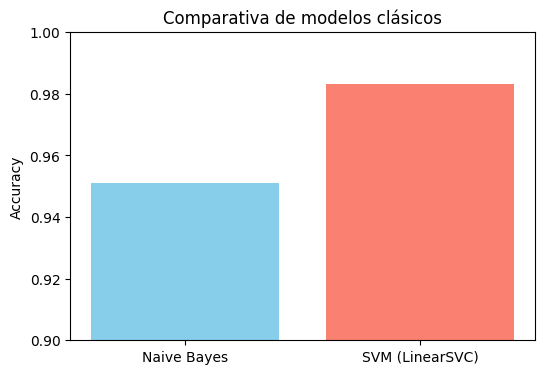

In [31]:
import pandas as pd


# Crear DataFrame con los resultados
results_df = pd.DataFrame(list(results.items()), columns=['Modelo', 'Accuracy'])

# Mostrar tabla
display(results_df)

# Gráfico de barras
plt.figure(figsize=(6,4))
plt.bar(results_df['Modelo'], results_df['Accuracy'], color=['skyblue', 'salmon'])
plt.ylim(0.9, 1.0)
plt.ylabel('Accuracy')
plt.title('Comparativa de modelos clásicos')
plt.show()

## Entrenamiento de una red neuronal usando **embeddings** (GloVe)

En vez de representar los emails como vectores dispersos (*TF-IDF*), vamos a usar **embeddings preentrenados de GloVe**. Así, cada palabra se representa como un vector denso que captura su significado y contexto.

**Ventajas de los embeddings:**
- Capturan relaciones semánticas y contexto entre palabras.
- Permiten a la red neuronal generalizar mejor ante expresiones poco frecuentes o sinónimos.

**Pasos principales:**
1. **Tokenización** y conversión de los emails a secuencias de índices.
2. **Carga de embeddings GloVe** preentrenados.
3. **Construcción de la matriz de embeddings** para nuestro vocabulario.
4. **Entrenamiento de una red neuronal secuencial** (LSTM) sobre las secuencias de embeddings.
5. **Comparación del rendimiento** con los modelos clásicos.

In [ ]:
# 1. Tokenización y secuenciado
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [39]:
# 2. Cargar embeddings GloVe (descargar si no lo tienes)

# Ruta y nombre del archivo
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "../data/glove.6B.zip"
glove_dir = "../data/"

# Descargar si no existe
if not os.path.exists(glove_zip_path):
    print("Descargando GloVe...")
    response = requests.get(glove_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB
    with open(glove_zip_path, "wb") as f, tqdm(
        desc="Descargando",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            f.write(data)
            bar.update(len(data))
    print("Descarga completada.")

# Descomprimir si no está descomprimido
if not os.path.exists(os.path.join(glove_dir, "glove.6B.100d.txt")):
    print("Descomprimiendo GloVe...")
    with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extractall(glove_dir)
    print("Descompresión completada.")

Descargando GloVe...


Descargando:   0%|          | 0.00/822M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
embedding_dim = 100
embedding_index = {}
with open("../data/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# 3. Crear la matriz de embeddings
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 4. Construir la red neuronal (LSTM sencilla)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Entrenar la red
history = model.fit(
    X_train_pad, y_train_enc,
    epochs=5, batch_size=64,
    validation_data=(X_test_pad, y_test_enc),
    verbose=2
)

# 6. Evaluar
loss, acc = model.evaluate(X_test_pad, y_test_enc, verbose=0)
print(f"\nAccuracy red neuronal (Embeddings+LSTM): {acc:.4f}")